# Applying the GP framework (Step 8)

In [2]:
import gpytorch
import torch
import numpy as np
import pandas as pd

from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from utils import metrics

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Step 8: Model  iteration

For ease of computation, swap the validation and test sets at the appropriate locations when ready to test. The next notebook will only test for the sparse GP model.

In [3]:
# Load data
train_df = pd.read_csv('data/training_set_tr.csv', index_col=[0])
val_df = pd.read_csv('data/validation_set_tr.csv', index_col=[0])
test_df = pd.read_csv('data/test_set_tr.csv', index_col=[0])

### 8.1. Baselines

We start by computing two baselines: linear regression and k-nearest neighbours. These benchmarks use x-y cooordinates only.

In [10]:
xtrain = train_df[['x', 'y']]
ytrain = train_df['dhdt_filt_tr']

xval = val_df[['x', 'y']]
yval = val_df['dhdt_filt_tr']

#xtest = test_df[['x', 'y']]
#ytest = test_df['dhdt_filt_tr']


#### 8.1.1. Linear regression

In [4]:
R2 = []
RMSE_mean = []
residuals = []
RMSE_5 = []
RMSE_95 = []

reg = LinearRegression().fit(xtrain, ytrain)

y_pred = reg.predict(xval)
residuals.append(yval - y_pred)

R2.append(r2_score(yval, y_pred))
RMSE_mean.append(mean_squared_error(
    yval, y_pred, squared=False))

p95 = np.percentile(yval, 95.0)
indx = [yval >= p95][0]
y_true_p95 = yval[indx]
y_pred_p95 = y_pred[indx]
RMSE_95.append(mean_squared_error(
    y_true_p95, y_pred_p95, squared=False))

p5 = np.percentile(yval, 5.0)
indx = [yval <= p5][0]
y_true_p5 = yval[indx]
y_pred_p5 = y_pred[indx]
RMSE_5.append(mean_squared_error(
    y_true_p5, y_pred_p5, squared=False))

In [5]:
print('Mean RMSE = ', RMSE_mean)
print('Mean R2 = ', R2)
print('95th percent. RMSE = ', RMSE_95)
print('5th percent. RMSE = ', RMSE_5)

Mean RMSE =  [0.40321280508715884]
Mean R2 =  [0.03199360999237322]
95th percent. RMSE =  [0.2493372195548166]
5th percent. RMSE =  [1.6477122242508584]


#### 8.1.2. K-NN

In [6]:
R2 = []
RMSE_mean = []
residuals = []
RMSE_5 = []
RMSE_95 = []

neigh = KNeighborsRegressor(n_neighbors=10, weights='distance')
neigh.fit(xtrain, ytrain)
y_pred = neigh.predict(xval)

R2.append(r2_score(yval, y_pred))
residuals.append(yval - y_pred)

RMSE_mean.append(mean_squared_error(
    yval, y_pred, squared=False))

p95 = np.percentile(yval, 95.0)
indx = [yval >= p95][0]
y_true_p95 = yval[indx]
y_pred_p95 = y_pred[indx]
RMSE_95.append(mean_squared_error(
    y_true_p95, y_pred_p95, squared=False))


p5 = np.percentile(yval, 5.0)
indx = [yval <= p5][0]
y_true_p5 = yval[indx]
y_pred_p5 = y_pred[indx]
RMSE_5.append(mean_squared_error(
    y_true_p5, y_pred_p5, squared=False))

print('Mean RMSE = ',  np.mean(RMSE_mean))
print('Mean R2 = ',  np.mean(R2))
print('95th percent. RMSE = ', np.mean(RMSE_95))
print('5th percent. RMSE = ',  np.mean(RMSE_5))


Mean RMSE =  0.07250504374531871
Mean R2 =  0.9686998779974756
95th percent. RMSE =  0.0841671272867531
5th percent. RMSE =  0.2640047954830447


### 8.2. Smart chunking

We need to evaluate the kernel design on the whole training data. Before applying a scaling method (Step 9), we divide the data into smaller sections. This can be done naively with an arbitrary grid or more intelligently with a clustering algorithm on the important features. We try the latter with k-means clustering with different input feature combinations:

* 'x', 'y'
* 'x', 'y', 'elev'
* 'x', 'y', 'ocean_dist'
* 'x', 'y', 'elev', 'ocean_dist'


In [6]:
## Split training set

# 'x', 'y'
# 'x', 'y', 'elev'
# 'x', 'y', 'ocean_dist'
# 'x', 'y', 'elev', 'ocean_dist'

kmeans = KMeans(n_clusters=100, random_state=0,
                n_init="auto").fit(train_df[['x', 'y', 'ocean_dist']])
train_df['groups'] = kmeans.labels_

1497


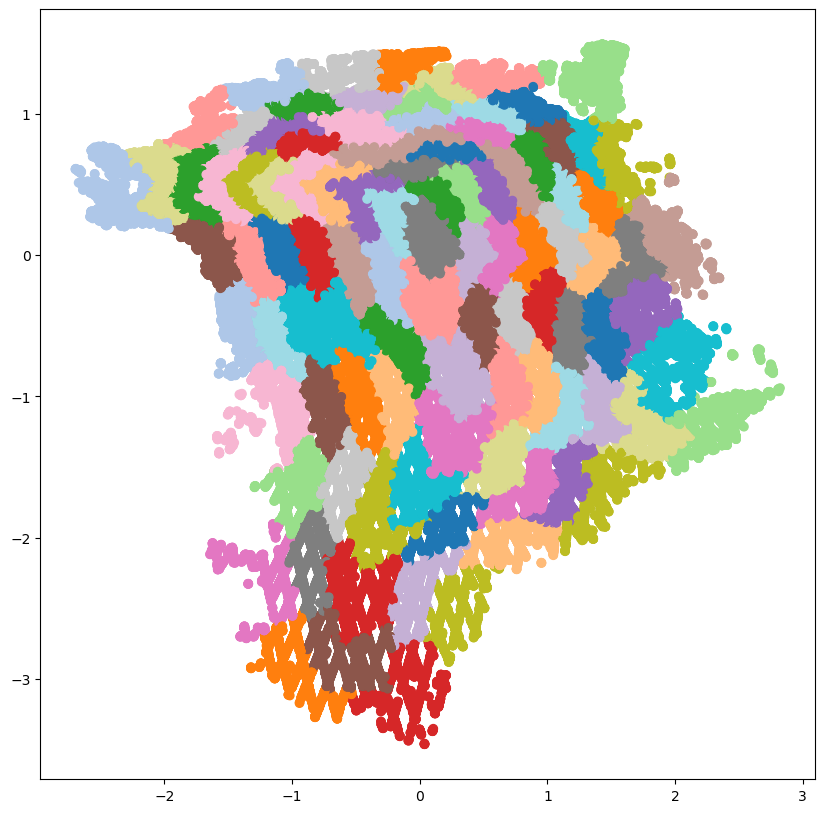

In [7]:
plt.figure(figsize=(10, 10))
plt.scatter(x=train_df['x'], y=train_df['y'],
            c=train_df['groups'], cmap='tab20')
print(train_df['groups'].value_counts().min())

In [8]:
print(train_df['groups'].value_counts().median())

3544.5


In [9]:
# split validation and test set
val_df['groups'] = kmeans.predict(val_df[['x', 'y', 'ocean_dist']])
test_df['groups'] = kmeans.predict(test_df[['x', 'y', 'ocean_dist']])

In [ ]:
# Fit the data

R2 = []
R2_untr = []
RMSE_95 = []
RMSE_5 = []
MLL = []

training_iter = 100

for k in tqdm(range(1000)):

    xtrain = train_df[train_df['groups'] == k][[
        'x', 'y', 'elev', 'ocean_dist']].values  #
    ytrain = train_df[train_df['groups'] == k]['dhdt_filt_tr'].values
    xval = val_df[val_df['groups'] == k][[
        'x', 'y', 'elev', 'ocean_dist']].values
    yval = val_df[val_df['groups'] == k]['dhdt_filt_tr'].values
    train_x, train_y = torch.Tensor(xtrain), torch.Tensor(ytrain)
    val_x = torch.Tensor(xval)

    # initialize likelihood and model
    noise_level = 0.0
    noise = noise_level*torch.ones(train_x.shape[0])
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise)
    model = ExactGPModel(train_x, train_y, likelihood, kernel10)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    # Includes GaussianLikelihood parameters

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        '''
        print('Iter %d/%d - Loss: %.3f ' % (
            i + 1 , training_iter, loss.item(),))
            #model.covar_module.base_kernel.lengthscale.item(),
        #model.likelihood.noise.item()))  noise: %.3f'
        '''
        optimizer.step()

    if len(xval) > 2:

        model.eval()
        likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            preds = likelihood(model(val_x))
            y_pred = preds.mean.numpy()
            y_var = preds.variance.numpy()

        R2.append(r2_score(yval, y_pred))

        RMSE_mean.append(mean_squared_error(
            yval, y_pred, squared=False))

        MLL.append(metrics.mll(yval, y_pred, y_var))

        p95 = np.percentile(yval, 95.0)
        indx = [yval >= p95][0]
        y_true_p95 = yval[indx]
        y_pred_p95 = y_pred[indx]
        RMSE_95.append(mean_squared_error(
            y_true_p95, y_pred_p95, squared=False))

        p5 = np.percentile(yval, 5.0)
        indx = [yval <= p5][0]
        y_true_p5 = yval[indx]
        y_pred_p5 = y_pred[indx]
        RMSE_5.append(mean_squared_error(
            y_true_p5, y_pred_p5, squared=False))


In [ ]:
print('Mean RMSE = ', np.mean(RMSE_mean), '±', np.std(RMSE_mean))
print('Mean R2 = ', np.mean(R2), '±', np.std(R2))
print('95th percent. RMSE = ', np.mean(RMSE_95), '±', np.std(RMSE_95))
print('5th percent. RMSE = ', np.mean(RMSE_5), '±', np.std(RMSE_5))
print('MLL= ', np.mean(MLL), '±', np.std(MLL))


### 8.3. Kernels to try

First attempt:
1. We start with SE kernel on a subset of the data using only x-y
2. As we are modelling a physical process, we choose the base kernel to Matern 52 which allows for discontinuties at 2nd derivative order.
3. Add the most linearly predictive variable (elev)
4. Add the second most linearly predictive varible (slope)
5. Add the third most predictive variable (ocean sistance)

In [52]:
# Multiplicative kernels
kernel1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2, active_dims=[0, 1]))
kernel2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=2, active_dims=[0, 1]))
kernel3 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=3, active_dims=[0, 1, 2]))
kernel4 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=4, active_dims=[0, 1, 2, 3]))
kernel5 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=5, active_dims=[0, 1, 2, 3, 4]))
kernel6 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=1, active_dims=[2]))

In [3]:
# Additative kernels
kernel7 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=2, active_dims=[
                                  0, 1]) + gpytorch.kernels.MaternKernel(nu=2.5, active_dims=[2]))
kernel8 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=3, active_dims=[
                                  0, 1, 2]) + gpytorch.kernels.MaternKernel(nu=2.5, active_dims=[3]))

kernel9 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=3, active_dims=[0, 1, 2])
    + gpytorch.kernels.MaternKernel(nu=2.5, active_dims=[3,4])
    + gpytorch.kernels.MaternKernel(nu=2.5, active_dims=[4]))


In [4]:
kernel10 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=3, active_dims=[
                                  0, 1, 2]) + gpytorch.kernels.MaternKernel(nu=1.5, active_dims=[3]))

In [5]:
k1 = gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=3, active_dims=[0, 1, 2])
k1.lengthscale = torch.Tensor([0.01, 0.01, 0.01])
k2 = gpytorch.kernels.MaternKernel(nu=1.5, active_dims=[3])
k2.lengthscale = torch.Tensor([0.01])

kernel11 = gpytorch.kernels.ScaleKernel(k1+ k2)


In [6]:
prior = gpytorch.priors.NormalPrior(loc=0.1, scale=0.1)
kernel12 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=2, active_dims=[
                                  0, 1,], lengthscale_prior=prior)+ gpytorch.kernels.MaternKernel(nu=1.5, active_dims=[2]) + gpytorch.kernels.MaternKernel(nu=1.5, active_dims=[3]))

In [7]:
# Define the GP model

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### 8.4. Iterations

In [10]:

# Divide the data into arbitrary chunks
squares = []

min_x = val_df.x.min()  # study area extent
min_y = val_df.y.min()
max_x = val_df.x.max()
max_y = val_df.y.max()

res = 0.1  # arbitrary resolution

for n in tqdm(np.arange(min_x, max_x, res)):

    for m in np.arange(min_y, max_y, res):

        df_chunk_train = train_df[(train_df.x >= n) & (
            train_df.x < n+res) & ((train_df.y >= m) & (train_df.y < m+res))]

        df_chunk_test = test_df[(test_df.x >= n) & (
            test_df.x < n+res) & ((test_df.y >= m) & (test_df.y < m+res))]

        if len(df_chunk_test.values) > 2:
            ytrain = df_chunk_train['dhdt_filt_tr'].values
            # , 'elev', 'ocean_dist']]
            xtrain = df_chunk_train[['x', 'y', 'elev', 'ocean_dist']].values
            xtest = df_chunk_test[['x', 'y', 'elev', 'ocean_dist']].values
            ytest = df_chunk_test['dhdt_filt_tr'].values
            squares.append([xtrain, ytrain, xval, yval])  # xtest, ytest])


100%|██████████| 55/55 [00:09<00:00,  5.91it/s]


In [11]:
# Fit the data

R2 = []
RMSE_mean = []
RMSE_95 = []
RMSE_5 = []
MLL = []
lengthscales = []
residuals = []
y_preds = []

training_iter = 150

for square in tqdm(squares):

    try:

        xtrain, ytrain, xval, yval = square
        train_x, train_y = torch.Tensor(xtrain), torch.Tensor(ytrain)
        val_x = torch.Tensor(xval)

        
        # initialize likelihood and model
        noise_level = 0.1
        noise = noise_level*torch.ones(len(xtrain))
        likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise)
        model = ExactGPModel(train_x, train_y, likelihood, kernel10)

        # Find optimal model hyperparameters
        model.train()
        likelihood.train()

        # Use the adam optimizer
        # Includes GaussianLikelihood parameters

        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()
            '''
            print('Iter %d/%d - Loss: %.3f ' % (
                i + 1 , training_iter, loss.item(),))
                #model.covar_module.base_kernel.lengthscale.item(),
            #model.likelihood.noise.item()))  noise: %.3f'
            '''
            optimizer.step()

        model.eval()
        likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            test_noises = torch.ones(len(val_x)) * 0.1
            preds = likelihood(model(val_x), noise=test_noises)
            y_pred = preds.mean.numpy()
            y_var = preds.variance.numpy()

        R2.append(r2_score(yval, y_pred))
        # R2_untr.append(r2_score(np.nan_to_num(np.log(yval)*4),np.nan_to_num(np.log(y_pred)*4)))

        RMSE_mean.append(mean_squared_error(
            yval, y_pred, squared=False))
        # RMSE_mean_untr.append(mean_squared_error(np.nan_to_num(np.log(yval)*4),np.nan_to_num(np.log(y_pred)*4), squared=False))

        MLL.append(metrics.mll(yval, y_pred, y_var))
        ls = model.covar_module.lengthscale
        lengthscales.append(ls)
        residuals.append(yval - y_pred)
        y_preds.append(y_preds)

        p95 = np.percentile(yval, 95.0)
        indx = [yval >= p95][0]
        y_true_p95 = yval[indx]
        y_pred_p95 = y_pred[indx]
        RMSE_95.append(mean_squared_error(
            y_true_p95, y_pred_p95, squared=False))
        # RMSE_95_untr.append(mean_squared_error(np.nan_to_num(np.log(y_true_p95)*4), np.nan_to_num(np.log(y_pred_p95)*4), squared=False))

        p5 = np.percentile(yval, 5.0)
        indx = [yval <= p5][0]
        y_true_p5 = yval[indx]
        y_pred_p5 = y_pred[indx]
        RMSE_5.append(mean_squared_error(
            y_true_p5, y_pred_p5, squared=False))
        # RMSE_5_untr.append(mean_squared_error(np.nan_to_num(np.log(y_true_p5)*4),np.nan_to_num(np.log(y_pred_p5)*4), squared=False))
    
    except:
        pass
  

  5%|▍         | 73/1502 [00:49<10:43,  2.22it/s] /Users/kenzatazi/miniconda3/envs/gp-frame/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:A not p.d., added jitter of 1.0e-06 to the diagonal
 /Users/kenzatazi/miniconda3/envs/gp-frame/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:A not p.d., added jitter of 1.0e-05 to the diagonal
 /Users/kenzatazi/miniconda3/envs/gp-frame/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:A not p.d., added jitter of 1.0e-04 to the diagonal
100%|██████████| 1502/1502 [20:08<00:00,  1.24it/s]


In [12]:
print('Mean RMSE = ', np.mean(RMSE_mean), '±', np.std(RMSE_mean))
print('Mean R2 = ', np.mean(R2), '±', np.std(R2))
print('95th percent. RMSE = ', np.mean(RMSE_95), '±', np.std(RMSE_95))
print('5th percent. RMSE = ', np.mean(RMSE_5), '±', np.std(RMSE_5))
print('MLL= ', np.mean(MLL), '±', np.std(MLL))

Mean RMSE =  0.1709678654235433 ± 0.32315881681941205
Mean R2 =  0.23630738010559987 ± 0.9247840740718671
95th percent. RMSE =  0.22912412332816806 ± 0.41256604230716326
5th percent. RMSE =  0.26161751508039666 ± 0.5552147701873266
MLL=  0.009559504029971725 ± 0.5625000367159257


### 8.5. Checks

### Lengthscales

In [71]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')

Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(-0.2509, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(-3.0486, requires_grad=True)
Parameter name: covar_module.base_kernel.kernels.0.raw_lengthscale value = Parameter containing:
tensor([[-2.2665, -5.5794]], requires_grad=True)
Parameter name: covar_module.base_kernel.kernels.1.raw_lengthscale value = Parameter containing:
tensor([[-0.1546]], requires_grad=True)
Parameter name: covar_module.base_kernel.kernels.2.raw_lengthscale value = Parameter containing:
tensor([[89.2638]], requires_grad=True)


#### Residuals

 /var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_72729/3500494018.py:2: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


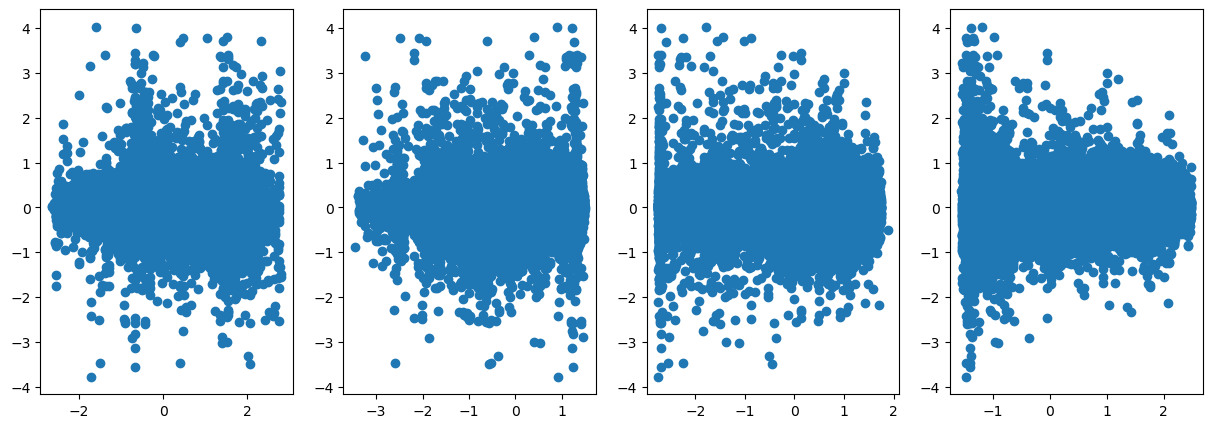

In [199]:
residual_arr = np.concatenate(residuals, axis=0)
xval = np.concatenate(np.array(squares)[:,2], axis=0)

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(4):
    axes[i].scatter(xval[:,i], residual_arr)

 /var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_72729/3580034709.py:1: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


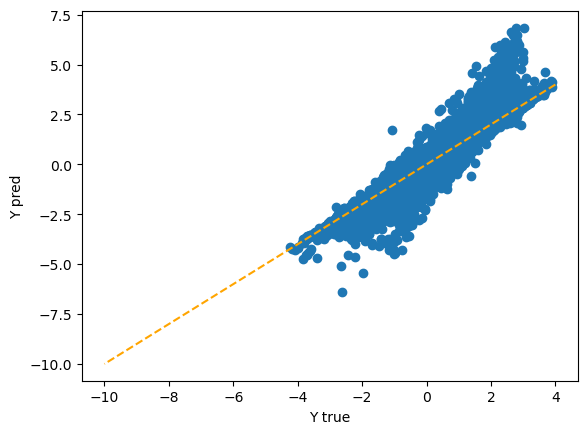

In [200]:

yval = np.concatenate(np.array(squares)[:,3], axis=0)
plt.scatter(yval, yval+residual_arr)
plt.xlabel('Y true')
plt.ylabel('Y pred')
plt.plot([4,-10], [4,-10], linestyle='--', c='orange')


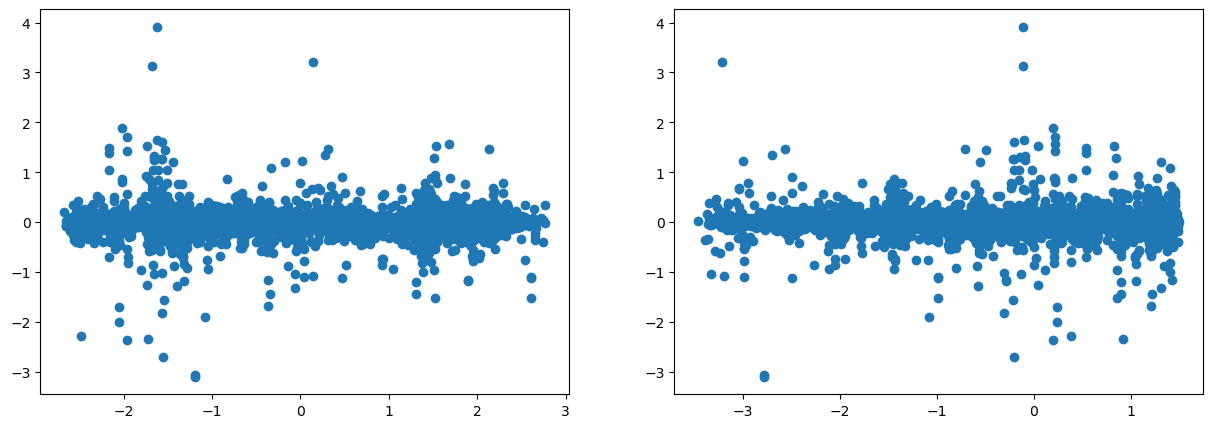

In [208]:
residual_arr = np.concatenate(residuals, axis=0)
fig, axes = plt.subplots(1,2, figsize=(15,5))
for i in range(2):
    axes[i].scatter(xval[:,i], residual_arr)

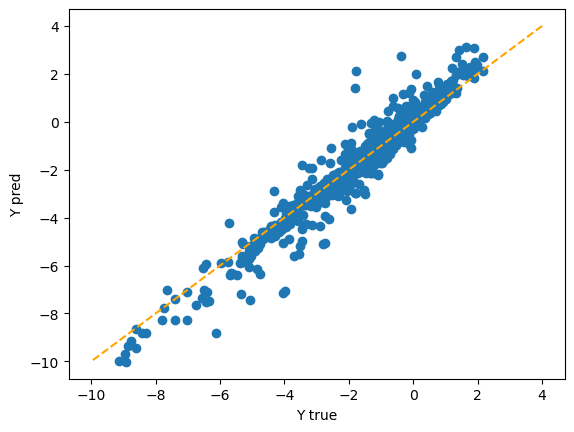

In [209]:
plt.scatter(yval, yval+residual_arr)
plt.xlabel('Y true')
plt.ylabel('Y pred')
plt.plot([4, -10], [4, -10], linestyle='--', c='orange')


#### Plots

##### Baselines

In [ ]:
df_linreg_test = pd.read_csv('data/plot_test_data.csv',
                             usecols=['elev', 'slope', 'x', 'y', 'aspect', 'ocean_dist', 'vel'])
df_linreg_test['vel_log'] = np.log(df_linreg_test['vel'])
df_linreg_test['slope_log'] = np.log(df_linreg_test['slope'])

In [ ]:
df_linreg_test[['elev', 'ocean_dist', 'slope_log', 'vel_log', 'aspect', 'x', 'y']] = scaler.transform(
    df_linreg_test[['elev', 'ocean_dist', 'slope_log', 'vel_log', 'aspect', 'x', 'y']])

In [ ]:
y_pred = neigh.predict(df_linreg_test[['x', 'y']])
df_linreg_test['ypred_knn'] = y_pred

In [264]:
df_linreg_test[['x','y', 'ypred']].to_csv('data/knn_output.csv')

<Axes: xlabel='x', ylabel='y'>

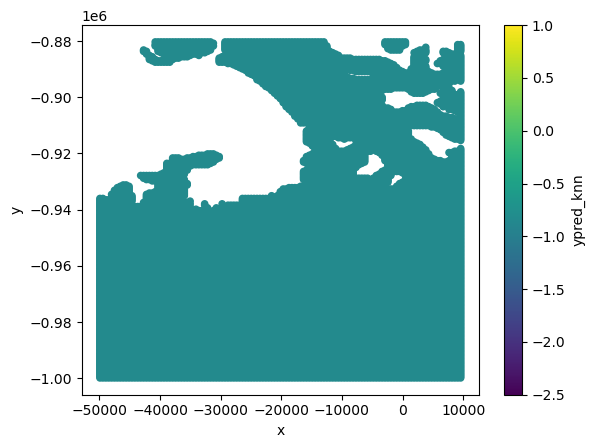

In [187]:
df_linreg_test.plot.scatter(x='x', y='y', c='ypred_knn', vmin=-2.5, vmax=1)

##### Chunked GP output

In [29]:
df_plot_train = pd.read_csv('data/plot_train_data.csv')
df_plot = pd.read_csv('data/plot_test_data.csv')

In [31]:
scaler = StandardScaler().fit(
    df_plot_train[['elev', 'ocean_dist', 'x', 'y']])
df_plot_train[['elev', 'ocean_dist', 'x_tr', 'y_tr']] = scaler.transform(
    df_plot_train[['elev', 'ocean_dist', 'x', 'y']])
df_plot[['elev', 'ocean_dist', 'x_tr', 'y_tr']] = scaler.transform(
    df_plot[['elev', 'ocean_dist', 'x', 'y']])
xplot = df_plot[['x_tr', 'y_tr', 'elev', 'ocean_dist']].values

In [32]:
xtrain = df_plot_train[['x', 'y', 'elev', 'ocean_dist']].values
ytrain = df_plot_train['dhdt_filt_tr'].values

In [33]:
train_x, train_y = torch.Tensor(xtrain), torch.Tensor(ytrain)
val_x = torch.Tensor(xplot)

In [34]:
noise_level = 0.1
noise = noise_level*torch.ones(len(xtrain))
likelihood = gpytorch.likelihoods.GaussianLikelihood() #noise=noise)
model = ExactGPModel(train_x, train_y, likelihood, kernel1)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
# Includes GaussianLikelihood parameters

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    '''
    print('Iter %d/%d - Loss: %.3f ' % (
        i + 1 , training_iter, loss.item(),))
        #model.covar_module.base_kernel.lengthscale.item(),
    #model.likelihood.noise.item()))  noise: %.3f'
    '''
    optimizer.step()

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_noises = torch.ones(len(val_x)) * 0.1
    preds = likelihood(model(val_x), noise=test_noises)
    y_pred = preds.mean.numpy()
    y_var = preds.variance.numpy()

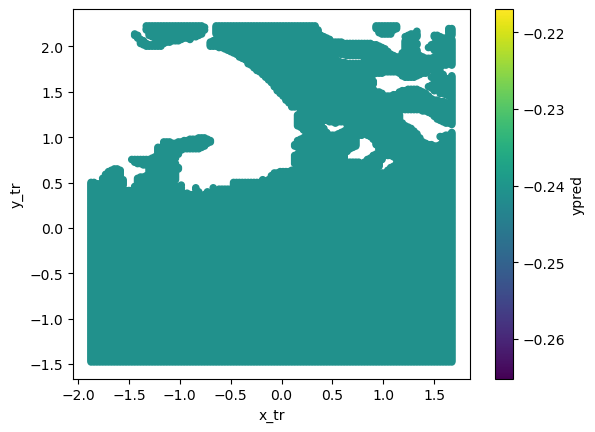

In [35]:
df_plot['ypred'] = y_pred
df_plot.plot.scatter(x='x_tr', y='y_tr', c='ypred')
df_plot[['x', 'y']]
df_plot[['x', 'y', 'ypred']].to_csv('data/se_ard_output.csv')
